In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def write_tiff_data_into_tensor(path):
    inputTensor = []
    files = [file for file in os.listdir(path) if file[-4:]=='.tif']
    files = sorted(files, key=lambda x:int(x.partition('126054_')[2].partition('_')[0]))
    for file in files:
        image = Image.open(os.path.join(path, file))
        image = np.asarray(image)
        inputTensor.append(image)
    inputTensor = np.asarray(inputTensor)
    return inputTensor
    
def write_tiff_data_into_text_file(pathIn='data\\Tiff_Image', pathOut='data\\text_data'):
    labels_tensor = []
    files = [file for file in os.listdir(path) if file[-4:]=='.tif']
    files = sorted(files, key=lambda x:int(x.partition('126054_')[2].partition('_')[0]))
    for file in files:
        label = Image.open(os.path.join(path, file))
        label = np.asarray(label)
        labels_tensor.append(label)
    labels_tensor = np.asarray(labels_tensor)
    for name, label in zip(files, labels_tensor):
        c=0
        f = open(os.path.join(pathOut,name[:-4]+'.txt'), '+w')
        for line in label:
            for sample in line:
                f.write('{}'.format(sample))
            c=c+1
            if c < label.shape[0]: #i hate EOF new line
                f.write('\n')
        f.close()

def write_text_data_into_tensor(path):
    inputTensor = []
    files = [file for file in os.listdir(path) if file[-4:]=='.txt']
    files = sorted(files, key=lambda x:int(x.partition('126054_')[2].partition('_')[0]))
    for file in files:
        with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
            lines = f.read().split('\n')
        dataPoint = []
        for line in lines:
            tmp = []
            for value in line:
                tmp.append(int(value))
            dataPoint.append(tmp)
        dataPoint = np.asarray(dataPoint, dtype=np.uint8)
        inputTensor.append(dataPoint)
    inputTensor = np.asarray(inputTensor, dtype = np.uint8)
    return inputTensor

def write_tensor_into_funksvd_format(inputTensor: np.ndarray, path):
    inputTensor = np.expand_dims(inputTensor, axis=-1)
    oldShape = inputTensor.shape
    inputTensor = np.reshape(inputTensor, (oldShape[0], oldShape[1]*oldShape[2], oldShape[3]))
    with open(path, 'w') as f:
        for user_id, img in enumerate(inputTensor):
            for movie_id, _ in enumerate(inputTensor[user_id]):
                for rating in inputTensor[user_id, movie_id]:
                    if (rating != 1):
                        f.write("{}\t{}\t{}".format(user_id+1, movie_id+1, rating))
                        f.write("\n")
    inputTensor.reshape(oldShape)

def read_txt_file_into_df(path):
    names = ['u_id', 'i_id', 'rating']
    dtype = {'u_id': np.uint32, 'i_id': np.uint32, 'rating': np.float64}
    df = pd.read_csv(svdDataPath, names=names, dtype=dtype, sep='\t')
    return df

def write_tensor_into_images(path, inputTensor):
    for c,i in enumerate(inputTensor):
        image = Image.fromarray(i)
        image.save(os.path.join(path, str(c)+'.png'))
    

rgb_mapping = np.asarray([[43, 131, 186],[246,144, 83],[145, 203, 169], [226, 240, 177], [214, 25, 28]], dtype=np.uint8)
#                           light blue  ,    Orange   ,  light green  , greenish yellow,      red  
#                              cloud    ,    Water    ,  Vegetation   ,   Aquaculture  ,     other

def color_map_from_classes_to_RGB(rgb_mapping, labels_tensor):
    #input: [no. data, width, heigth]
    #output: [no. data, width, height, RGB]
    old_shape = labels_tensor.shape
    labels_vector = np.reshape(labels_tensor, -1)

    temp = np.zeros(labels_vector.shape + (3,))
    for i,v in enumerate(labels_vector):
        temp[i] = rgb_mapping[v-1]
    temp = np.reshape(temp, old_shape + (3,))
    rs = temp.astype(np.uint8)
    return rs

def plot_class(img):
    plt.figure(figsize=(10,10))   
    plt.imshow(img)
    plt.title("tmp")
    plt.show()


In [2]:
tiffPath = 'data\Tiff_Image'
inputTensor = write_tiff_data_into_tensor(tiffPath)

TIEOFXTensor = []
TIEOFYTensor = [] 

for time,tensor in enumerate(inputTensor):
    for latitude,values in enumerate(tensor):
        for longitude,value in enumerate(values):
            if value != 1:
                temp = [latitude, longitude, time]
                temp = np.asarray(temp)
                TIEOFXTensor.append(temp)
                TIEOFYTensor.append(value)
TIEOFXTensor = np.asarray(TIEOFXTensor)
TIEOFYTensor = np.asarray(TIEOFYTensor)

In [9]:
from tieof import model

tensorShape = np.asarray([inputTensor.shape[1], inputTensor.shape[2], inputTensor.shape[0]])
R = 5
dineof3 = model.DINEOF3(R = R, tensor_shape=tensorShape, decomp_type='HOOI')
dineof3.fit(X = TIEOFXTensor, y=TIEOFYTensor)

Reconstruction:   4%|▍         | 12/300 [00:14<05:48,  1.21s/it, error=0.00667, rel_error=0.000943]


In [4]:
from tensorly.decomposition.candecomp_parafac import initialize_factors

In [5]:
import numpy as np
from numpy.random import default_rng
import cv2
import skimage

def create_random_blob(matrix: np.ndarray):
    rng = default_rng()
    noise = rng.integers(0,255, matrix.shape, np.uint8, True)

    blur = cv2.GaussianBlur(noise, (0,0), sigmaX=15, sigmaY=15, borderType = cv2.BORDER_DEFAULT)
    strech = skimage.exposure.rescale_intensity(blur,  in_range = 'image', out_range = (0,255)).astype(np.uint8)

    thresh = cv2.threshold(strech, 175,1, cv2.THRESH_BINARY)[1]

    size = rng.integers(3, 5, 2, np.uint8, True)
    #rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, size)
    ellipKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, size)
    #crossKernel = cv2.getStructuringElement(cv2.MORPH_CROSS, size)
    # kernels = [rectKernel, ellipKernel]
    # r1 = rng.integers(low=0, high=1, dtype=np.uint8, endpoint=True)
    # r2 = rng.integers(low=0, high=1, dtype=np.uint8, endpoint=True)

    result = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, ellipKernel)
    result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, ellipKernel)
    
    return result

def create_random_clouds(matrix: np.ndarray, min_percent, value):
    w, h = matrix.shape
    noise_matrix = np.copy(matrix)

    indices = np.argwhere(noise_matrix == value)

    current_percent = len(indices)/(w*h)
    while current_percent < min_percent:
        temp = create_random_blob(noise_matrix)
        indices = np.argwhere(temp == value)
        for i,j in indices:
            noise_matrix[i,j] = value
        indices = np.argwhere(noise_matrix == value)
        current_percent = len(indices)/(w*h)
    return noise_matrix

import numpy as np

def adding_synthetic_data_into_tensor(inputTensor: np.ndarray, threshold, value):
    realDataShape = inputTensor.shape
    w = realDataShape[1]
    h = realDataShape[2]
    for image in inputTensor:
        indices = np.argwhere(image == value)
        current_percent = len(indices)/(w*h)
        interval = (threshold - current_percent)/20
        while current_percent < threshold:
            current_percent += interval
            imputed_matrix = create_random_clouds(image, current_percent, value)
            imputed_matrix = np.expand_dims(imputed_matrix, axis=0)
            inputTensor = np.append(inputTensor, imputed_matrix, axis=0)
    return inputTensor, realDataShape

In [30]:
inputTensor, oldShape = adding_synthetic_data_into_tensor(inputTensor, 0.15, 1)
print(oldShape)
inputTensor.shape

(6, 909, 879)


(87, 909, 879)

In [19]:
path = 'data\\funk_svd_format_data\\images'
imageTensor = color_map_from_classes_to_RGB(rgb_mapping, inputTensor)
write_tensor_into_images(path, imageTensor)

In [23]:
svdDataPath = 'data/funk_svd_format_data/real_and_synthetic_data'
write_tensor_into_funksvd_format(inputTensor, svdDataPath)

In [27]:
import pandas as pd
import numpy as np

svdDataPath = 'data/funk_svd_format_data/real_and_synthetic_data'
df = read_txt_file_into_df(path)

In [28]:
df['rating'].value_counts()

2.0    24821036
4.0    22176866
3.0     7340545
5.0     4516063
Name: rating, dtype: int64

In [6]:
from funk_svd import SVD
from sklearn.metrics import mean_absolute_error


train = df.sample(frac=0.8, random_state = 7)
val = df.drop(train.index.tolist()).sample(frac=0.5, random_state=8)
test = df.drop(train.index.tolist()).drop(val.index.tolist())

svd = SVD(lr=0.001, reg=0.001, n_epochs=500, n_factors=100, early_stopping=True, shuffle=True, min_rating=2, max_rating=5)

svd.fit(X=train, X_val=val)

Preprocessing data...

Preprocessing data...

Epoch 1/500  | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.90 - took 48.7 sec
Epoch 2/500  | val_loss: 0.28 - val_rmse: 0.53 - val_mae: 0.37 - took 45.0 sec
Epoch 3/500  | val_loss: 0.21 - val_rmse: 0.46 - val_mae: 0.26 - took 44.8 sec
Epoch 4/500  | val_loss: 0.21 - val_rmse: 0.45 - val_mae: 0.25 - took 44.1 sec
Epoch 5/500  | val_loss: 0.20 - val_rmse: 0.45 - val_mae: 0.25 - took 48.1 sec
Epoch 6/500  | val_loss: 0.20 - val_rmse: 0.45 - val_mae: 0.26 - took 47.4 sec
Epoch 7/500  | val_loss: 0.19 - val_rmse: 0.43 - val_mae: 0.25 - took 44.0 sec
Epoch 8/500  | val_loss: 0.16 - val_rmse: 0.41 - val_mae: 0.25 - took 45.0 sec
Epoch 9/500  | val_loss: 0.14 - val_rmse: 0.37 - val_mae: 0.22 - took 45.9 sec
Epoch 10/500 | val_loss: 0.12 - val_rmse: 0.35 - val_mae: 0.20 - took 45.6 sec
Epoch 11/500 | val_loss: 0.11 - val_rmse: 0.34 - val_mae: 0.18 - took 46.2 sec
Epoch 12/500 | val_loss: 0.11 - val_rmse: 0.33 - val_mae: 0.17 - took 51.1 sec
Epoch 

In [19]:
import pickle
with open('temp.svd', 'wb') as f:
    pickle.dump(svd, f)

In [22]:
import pickle
with open('temp.svd', 'rb') as f:
    svd = pickle.load(f)

In [7]:
pred = svd.predict(test)
mae = mean_absolute_error(test['rating'], pred)

print(mae)

0.03939243945150169


In [23]:
oldShape = inputTensor.shape
temp = []

for i in range(1,oldShape[1]*oldShape[2]+1):
    temp.append(svd.predict_pair(6,i))
temp = np.asarray(temp)
temp = np.rint(temp)
temp = temp.astype(np.uint8)
rs = np.reshape(temp, (oldShape[1],oldShape[2]))

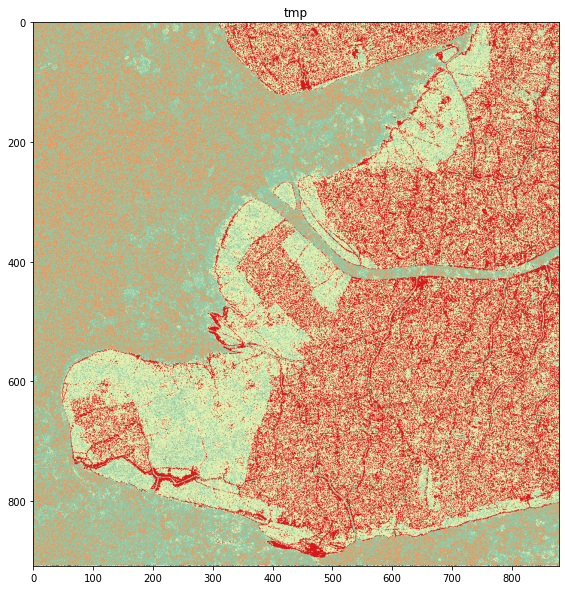

In [17]:
plot_class(color_map_from_classes_to_RGB(rgb_mapping, rs))

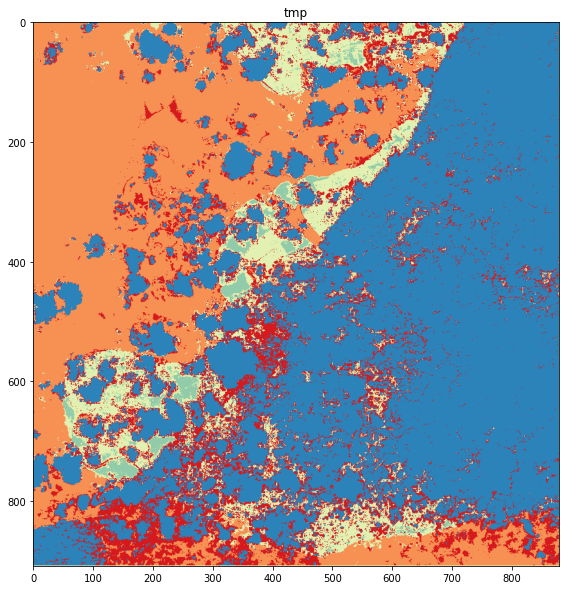

In [18]:
plot_class(color_map_from_classes_to_RGB(rgb_mapping, inputTensor[5]))